In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from multiprocessing import Pool
sys.path.append('../Module_Analysis/')
import Pair_Corelation_Function as PCF
#import Clustering as Clust
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend')
import Gillespie_backend as backend
import Simulate_System as SimSys
sys.path.append('/home/hcleroy/Extra_Module_py/')
import formated_matplotlib

In [2]:
# define the unit of the system :
dimension = 3

L = 1000
NLinker = 20

EbLow = -1.
EbHigh = -10.

kdiff = 0.000207352*5

seed = np.random.randint(0,1000000)

In [12]:
#Sys_Low_nrj = backend.Gillespie(    ell_tot=L,
#                                    rho0=0.,
#                                    BindingEnergy=EbLow,
#                                    kdiff=kdiff,
#                                    seed = seed,
#                                    Nlinker=NLinker,dimension=dimension)
#
#Sys_High_nrj = backend.Gillespie(    ell_tot=L,
#                                    rho0=0.,
#                                    BindingEnergy=EbHigh,
#                                    kdiff=kdiff,
#                                    seed = seed,
#                                    Nlinker=NLinker,dimension=dimension)
Syss = np.array([backend.Gillespie( ell_tot=L,
                                    rho0=0.,
                                    BindingEnergy=eb,
                                    kdiff=kdiff,
                                    seed = seed,
                                    Nlinker=NLinker,dimension=dimension) for eb in np.linspace(-10,0,10,endpoint=False)
])

In [4]:
def Make_Simulation(a0,a1,a2,a3,a4,a5,a6,step_tot):
    Sys = backend.Gillespie(ell_tot=a0,
                                    rho0=a1,
                                    BindingEnergy=a2,
                                    kdiff=a3,
                                    seed = a4,
                                    Nlinker=a5,dimension=a6)
    Sim = SimSys.Simulation(step_tot = step_tot,Gillespie = Sys)
    Sim.simulate_eq_distribution()
    return Sim.R,Sim.L,Sim.move

In [13]:
args = [(L,0.,eb,kdiff,seed,NLinker,dimension,10**5) for eb in np.linspace(-10,0,10,endpoint=False)]
pool = Pool(12)
Sims = pool.starmap(Make_Simulation,args)

In [14]:
Rs = np.array([Sims[i][0] for i in range(10)])
Ls = np.array([Sims[i][1] for i in range(10)])
moves = np.array([Sims[i][2] for i in range(10)])

In [15]:
#X_low,Y_low = PCF.compute_2_body_dist_prob(Sim_Low_nrj.R)
XYs = np.array([PCF.compute_2_body_dist_prob(rs) for rs in Rs])

/tmp/ipykernel_13783/1910732210.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


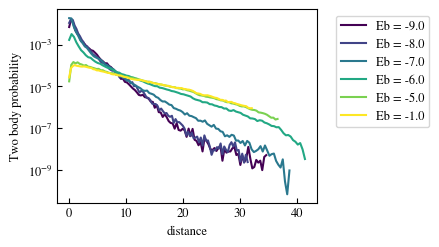

In [8]:
#plt.plot(X_low,Y_low,label='Eb = -1')
from matplotlib import cm
cmap = cm.get_cmap('viridis')
#plt.savefig('viridis.svg')
EBS = np.linspace(-10,0,10,endpoint=False)
i=0
for XY in XYs:
    i+=1
    if i>5 and i!=9:
        continue
    t = cmap((i-1)/5)
    plt.plot(XY[0],XY[1],label='Eb = '+str(EBS[i]),color=t)    
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('Two body probability')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('two_body_probability.svg',transparent=True,bbox_inches='tight')

## Now look at the time evolution of the Eb=-10 curve
Let us simulate 10 systems with different seeds. And proceed to compute the 2 body probability distribution function at 10 different timesteps

In [5]:
Nreplica=100
args = [(L,0.,-10,kdiff,np.random.randint(0,1000000),NLinker,dimension,10**4) for _ in range(Nreplica)]
pool = Pool(12)
Replica_10 = pool.starmap(Make_Simulation,args)

In [6]:
Rs_replica = np.array([Replica_10[i][0] for i in range(100)])
Ls_replica = np.array([Replica_10[i][1] for i in range(100)])

In [7]:
Rs10E6 = np.load('Res_Simul/step_10_E6_E_10_1_Rs.npy',allow_pickle=True)
Ls10E6 = np.load('Res_Simul/step_10_E6_E_10_1_Ls.npy',allow_pickle=True)

In [8]:
Nreplica=100
Nslice = 10
dt = Ls_replica[0].shape[0]//Nslice
nbins=100
G_time = np.zeros((Nslice,nbins),dtype=float)
X_replica = np.zeros((Nslice,nbins),dtype=float)
for i in range(Nslice):
    X_replica[i],G_time[i] = PCF.compute_2_body_dist_prob(np.concatenate(np.array([Rs_replica[j][i*dt:(i+1)*dt] for j in range(Nreplica)]),axis=0),nbins)

In [9]:
XE6,GE6 = PCF.compute_2_body_dist_prob(Rs10E6 ,nbins)

In [10]:
d = list()
for r in Rs_replica:
    d.append(np.mean(np.linalg.norm(r[-1],axis=1)))
d = np.array(d)

(array([ 6.,  7.,  9.,  4.,  8., 13.,  4.,  9., 12.,  4.,  8.,  1.,  4.,
         3.,  2.,  2.,  1.,  2.,  0.,  1.]),
 array([ 5.03320974,  6.14703807,  7.2608664 ,  8.37469474,  9.48852307,
        10.6023514 , 11.71617974, 12.83000807, 13.9438364 , 15.05766474,
        16.17149307, 17.2853214 , 18.39914973, 19.51297807, 20.6268064 ,
        21.74063473, 22.85446307, 23.9682914 , 25.08211973, 26.19594807,
        27.3097764 ]),
 <BarContainer object of 20 artists>)

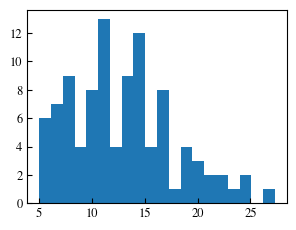

In [11]:
plt.hist(d,bins=20)

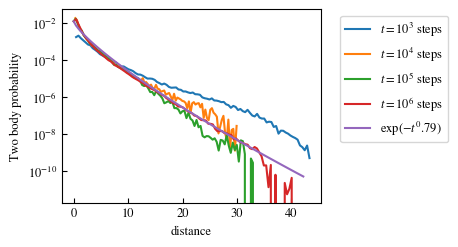

In [18]:
#for i in [0,9]:#range(Nslice):
#    t = cmap(i/10)
#    plt.plot(X_replica[i][1:],G_time[i][1:],label=i,color=t)
#i = 0
plt.plot(X_replica[0][1:],G_time[0][1:],label=r'$t = 10^3$ steps')
plt.plot(X_replica[9][1:],G_time[9][1:],label=r'$t = 10^4$ steps')
plt.plot(XYs[0][0],XYs[0][1],label=r'$t = 10^5$ steps')
plt.plot(XE6,GE6,label=r'$t = 10^6$ steps')
#plt.plot(XE6,np.exp(-(XE6-XE6[XE6.shape[0]//2])/2.5)*GE6[GE6.shape[0]//2],label=r'$t = 10^6$ steps')
plt.plot(XE6,np.exp(-XE6**0.79)*GE6[0],label=r'$\exp(-t^0.79)$')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('distance')
plt.ylabel('Two body probability')
#plt.savefig('two_body_probability_time.svg',transparent=True,bbox_inches='tight')

## Is the system evolves faster with less linkers ?

In [48]:
# Nlinker = 1
Nreplica=1000
args = [(L,0.,-10,kdiff,np.random.randint(0,1000000),3,dimension,10**4) for _ in range(Nreplica)]
pool = Pool(12)
Replica_10_N1 = pool.starmap(Make_Simulation,args)
Rs_replica_N1 = np.array([Replica_10_N1[i][0] for i in range(Nreplica)])
Ls_replica_N1 = np.array([Replica_10_N1[i][1] for i in range(Nreplica)])

In [51]:
Nslice = 100
dt = Ls_replica[0].shape[0]//Nslice
nbins=100
G_time_N1 = np.zeros((Nslice,nbins),dtype=float)
X_replica_N1 = np.zeros((Nslice,nbins),dtype=float)
for i in range(Nslice):
    X_replica_N1[i],G_time_N1[i] = PCF.compute_2_body_dist_prob(np.concatenate(np.array([Rs_replica_N1[j][i*dt:(i+1)*dt] for j in range(Nreplica)]),axis=0),nbins)

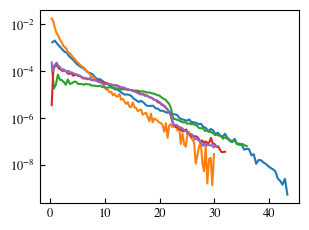

In [53]:
plt.plot(X_replica[0][1:],G_time[0][1:],label=r'$t = 10^3$ steps')
plt.plot(X_replica[9][1:],G_time[9][1:],label=r'$t = 10^4$ steps')
plt.plot(X_replica_N1[0][1:],G_time_N1[0][1:],label=r'$t = 10^2$ steps')
plt.plot(X_replica_N1[9][1:],G_time_N1[9][1:],label=r'$t = 10^3$ steps')
plt.plot(X_replica_N1[99][1:],G_time_N1[99][1:],label=r'$t = 10^4$ steps')
plt.yscale('log')

# Random old stuff (including clustering analysis)

In [22]:
def Compute_L_2_body_prob_replica(Ls,maxL=1001):
    Nslice = 10
    nbins = 100
    dL = maxL/nbins
    dt = Ls[0].shape[0]//Nslice
    r = np.zeros((Nslice,nbins),dtype=float)
    bins = np.array([i*dL for i in range(nbins)])
    def I(l):
        return int(l/dL)
    for i in range(Nslice):
        tmin,tmax = i*dt, (i+1)*dt
        flattenL = np.array([Ls[j][tmin:tmax] for j in range(10)]).flatten()
        flattenL = flattenL[np.argwhere(flattenL!=0)]
        for dl in flattenL:
            r[i,I(dl)] += 1
    return r,bins

In [23]:
r,bins = Compute_L_2_body_prob_replica(Ls)

(0.0, 200.0)

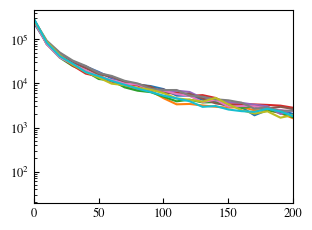

In [28]:
for i in range(10):
    plt.plot(bins,r[i])
plt.yscale('log')
plt.xlim(0,200)

In [30]:
print(Ls[0][100])
print(Ls[0][1000])
print(Ls[0][10000])
print(Ls[0][99999])

[  7.   4.  70.  14.  46. 393.  18.   7. 127.   6.   8.  17.  12. 102.
 169.   0.   0.   0.   0.   0.]
[  8.  39. 157.  36.  30.   3. 235.  33.  62.  15.  46.  42.  44.   8.
 123.  19.  91.   9.   0.   0.]
[136.   7.  17.   1.  14.   2.   2.   1.   6.   2.   2.   3.  11.  12.
  38.   3.   2. 741.   0.   0.]
[ 30.  13.  14.  78.   7.  53.  49. 323.   7.  12.   2.  28.   4.  19.
  15.   1. 136. 209.   0.   0.]


In [ ]:

XYs = np.array([PCF.compute_2_body_dist_prob(rs) for rs in Rs[0]])
#plt.plot(X_low,Y_low,label='Eb = -1')
cmap = matplotlib.cm.get_cmap('viridis')
#plt.savefig('viridis.svg')
EBS = np.linspace(-10,0,10,endpoint=False)
i=0
for XY in XYs:
    t = cmap(i/10)
    plt.plot(XY[0],XY[1],label='Eb = '+str(EBS[i]),color=t)
    i+=1
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('Two body probability')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('two_body_probability.svg',transparent=True,bbox_inches='tight')

In [33]:
for i in range(10):
    print(Ls[i,-1])

[123. 111. 130.   2.  10.  10.  25. 221. 204.   5.   4.  16.   6.   8.
  12.   3.   6.   1.  76.  27.]
[  1.   1.  13.   1.  16.   1.   2.   7.   8.  16.  62.  24.  38. 810.
   0.   0.   0.   0.   0.   0.]
[129. 303.  26.  11.  19.  90. 184.   1.   3.   4.  11.   8.  26. 185.
   0.   0.   0.   0.   0.   0.]
[412.   9.  15.  30.   9.   2.  30.  37.  12. 444.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]
[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]
[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]
[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]
[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0

In [47]:
#np.save('R_Eb_10.npy',Sim_High_nrj.R,allow_pickle=True)
#np.save('R_Eb_1.npy',Sim_Low_nrj.R,allow_pickle=True)


#R_High = np.load('R_Eb_10.npy',allow_pickle=True)
#R_Low = np.load('R_Eb_1.npy' ,allow_pickle=True)

R_High  = Sim_High_nrj.R
#R_Low  = Sim_Low_nrj.R

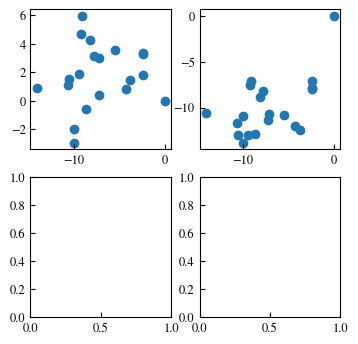

In [48]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize = (4,4))
ax[0,0].scatter(R_High[-1][:,0],R_High[-1][:,2])
ax[0,1].scatter(R_High[-1][:,0],R_High[-1][:,1])

#ax[0,0].scatter(R_High[0][:,0],R_Low[-1][:,2],color='red')
#ax[0,1].scatter(R_High[0][:,0],R_Low[-1][:,1],color='red')

In [49]:
print(Sys_High_nrj.get_ell())

[298.  86.   8.   8.  23.   7.  19.  24.  24.   5.   2. 308.  47.   6.
   8.   3.  53.   9.  11.  51.]


KMeans(n_clusters=3)

In [25]:
def split_data_per_cluster(kmeans,data):
    data_out = []
    for i in range(kmeans.n_clusters):   
        kmeans.labels_
        data_out.append(data[np.argwhere(kmeans.labels_==i)[:,0]])
    return data_out

In [26]:
data_splitted = split_data_per_cluster(kmeans,R_High[-1])

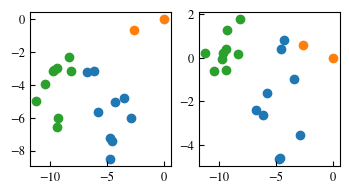

In [27]:
fig,ax = plt.subplots(ncols=2,figsize=(4,2))
for i in range(data_splitted.__len__()):
    ax[0].scatter(data_splitted[i][:,0],data_splitted[i][:,1])
    ax[1].scatter(data_splitted[i][:,0],data_splitted[i][:,2])

In [28]:
sse_end = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R_High[-1])
    sse_end.append(kmeans.inertia_)
sse_beg = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R_High[0])
    sse_beg.append(kmeans.inertia_)

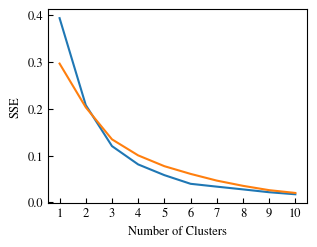

In [29]:
plt.plot(range(1, 11), np.array(sse_end)/sum(sse_end))
plt.plot(range(1, 11), np.array(sse_beg)/sum(sse_beg))
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [30]:
kl_end = KneeLocator(range(1, 11), sse_end, curve="convex", direction="decreasing")
kl_beg = KneeLocator(range(1, 11), sse_beg, curve="convex", direction="decreasing")

In [31]:
print(kl_end.elbow)
print(kl_beg.elbow)

3
4
